# Public Library Survey Data - Library similarity

In this notebook, we will attempt to group similar libraries together based on a number of dimensions such as budget, demographics, and engagement.

First we will read the 2022 public library data as well as three 2023 datasets from the Census: median houshold income, race, and ethnicity.

In [1]:
import pandas as pd
from helpers import *

lib_df = pd.read_csv("data/PLS_FY22_AE_pud22i.csv", encoding="latin-1")
print(f"Found {lib_df.shape[0]:,} entries from the public library survey")

income_df = pd.read_csv("data/ACSDT5Y2023.B19013-Data-Houshold-Income-By-Zipcode.csv", skiprows=[1])
print(f"Found {income_df.shape[0]:,} entries from the Census median household income dataset")

race_df = pd.read_csv("data/ACSDT5Y2023.B02001-Data-Race-By-Zipcode.csv", skiprows=[1])
print(f"Found {race_df.shape[0]:,} entries from the Census race dataset")

ethnicity_df = pd.read_csv("data/ACSDT5Y2023.B03003-Data-Hispanic-By-Zipcode.csv", skiprows=[1])
print(f"Found {ethnicity_df.shape[0]:,} entries from the Census ethnicity (Hispanic or Latino) dataset")

Found 9,248 entries from the public library survey
Found 33,772 entries from the Census median household income dataset
Found 33,772 entries from the Census race dataset
Found 33,772 entries from the Census ethnicity (Hispanic or Latino) dataset


Next we will merge the four datasets on zipcode

In [2]:
# Create a new column "GEO_ID" that will match the GEO_ID (zipcode) in the Census data
lib_df["GEO_ID"] = lib_df.apply(
    lambda row: f"860Z200US{str(row['ZIP']).zfill(5)}", axis=1
)
lib_df = pd.merge(lib_df, income_df, on="GEO_ID", how="left")
lib_df = pd.merge(lib_df, race_df, on="GEO_ID", how="left")
lib_df = pd.merge(lib_df, ethnicity_df, on="GEO_ID", how="left")
print(f"{lib_df.shape[0]:,} entries after merging")

9,248 entries after merging


Next let's make sure household income is an integer

In [3]:
# Parse income
lib_df["MEDIAN_INCOME"] = lib_df.apply(
    lambda row: parse_int(row["B19013_001E"]), axis=1
)
print(f"The median median houshold income is ${lib_df['MEDIAN_INCOME'].median():,}")

The median median houshold income is $70,078.5


Next let's create one column that represents percentage of population that are people of color or Hispanic/Latino.

In [4]:
lib_df = calculate_percent_pos(lib_df)
print(f"The median percent person of color or Hispanic/Latino per library is {lib_df['PERC_POC_OR_HISPANIC'].median():,}%")

The median percent person of color or Hispanic/Latino per library is 7.605%


Next let's make sure operating revenue are all valid numbers

In [5]:
# Parse income
lib_df["TOTINCM"] = lib_df.apply(
    lambda row: parse_int(row["TOTINCM"]), axis=1
)
print(f"The median operating revenue is ${lib_df['TOTINCM'].median():,}")

The median operating revenue is $283,943.0


Next, as proxies for engagement, let's calculate visits per capita, attendance per program, and computer/wifi sessions per capita

In [6]:
lib_df = calculate_per(lib_df, "VISITS", "POPU_LSA", "VISITS_PER")
print(f"The median visits per capita is {lib_df['VISITS_PER'].median():,}")
lib_df = calculate_per(lib_df, "TOTATTEN", "TOTPRO", "ATTEN_PER")
print(f"The median attendance per program is {lib_df['ATTEN_PER'].median():,}")
lib_df = calculate_per(lib_df, "WIFISESS", "VISITS", "WIFI_PER")
print(f"The median wifi sessions per visit is {lib_df['WIFI_PER'].median():,}")
lib_df = calculate_per(lib_df, "PITUSR", "VISITS", "COMP_PER")
print(f"The median computer sessions per visit is {lib_df['COMP_PER'].median():,}")

The median visits per capita is 2.4
The median attendance per program is 14.409
The median wifi sessions per visit is 0.122
The median computer sessions per visit is 0.094


Let's combine visits/attendance and wifi/computer into single scores for physical and digital engagement

In [7]:
lib_df["PHYS_ENGAGEMENT"] = lib_df.apply(lambda row: (row["VISITS_PER"] + row["ATTEN_PER"]) / 2.0, axis=1)
lib_df["DIGI_ENGAGEMENT"] = lib_df.apply(lambda row: (row["WIFI_PER"] + row["COMP_PER"]) / 2.0, axis=1)
print(f"The median physical engagement score is {lib_df['PHYS_ENGAGEMENT'].median():,}")
print(f"The median digital engagement score is {lib_df['DIGI_ENGAGEMENT'].median():,}")

The median physical engagement score is 8.90325
The median digital engagement score is 0.129


Next let's try to reduce these fields to 2 dimensions using [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)

In [8]:
from sklearn.preprocessing import StandardScaler
import umap

reducer = umap.UMAP()
columns_to_reduce = [
    "MEDIAN_INCOME",
    "TOTINCM",
    "PERC_POC_OR_HISPANIC",
    "PHYS_ENGAGEMENT",
    "DIGI_ENGAGEMENT"
]

# Get only the relevant data we need
lib_data = lib_df[columns_to_reduce].values
scaled_data = StandardScaler().fit_transform(lib_data)
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(9248, 2)

And plot the results on a scatter chart

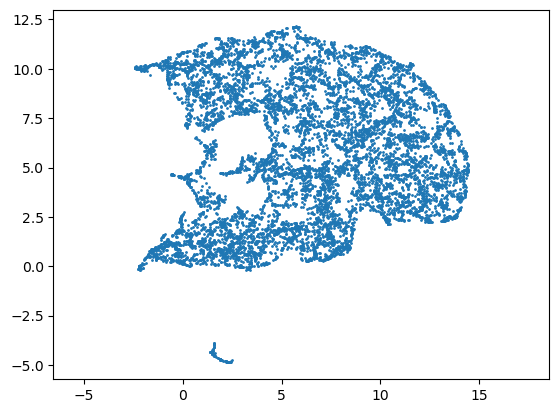

In [9]:
import matplotlib.pyplot as plt

plt.scatter(embedding[:, 0], embedding[:, 1], s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.show()

Now let's add the embeddings back to the original data, select one library (the Detroit Public Library), and display the most similar libraries based on the embeddings

In [11]:
import math

lib_df["EMBEDDING"] = lib_df.apply(lambda row: embedding[row.name], axis=1)
lib = find_where(lib_df, "LIBNAME", "DETROIT PUBLIC LIBRARY")
lib_df["DISTANCE"] = lib_df.apply(lambda row: math.dist(lib["EMBEDDING"], row["EMBEDDING"]), axis=1)
sorted_df = lib_df.sort_values("DISTANCE")
columns_to_display = ["LIBNAME", "CITY", "STABR"] + columns_to_reduce + ["DISTANCE"]
sorted_df[columns_to_display].head(10)


1


,LIBNAME,CITY,STABR,MEDIAN_INCOME,TOTINCM,PERC_POC_OR_HISPANIC,PHYS_ENGAGEMENT,DIGI_ENGAGEMENT,DISTANCE
3870,DETROIT PUBLIC LIBRARY,DETROIT,MI,36536,33348455,72.10,8.8340,0.5195,0.000000
4357,CITY OF ST. LOUIS MUNICIPAL LIBRARY DISTRICT,ST. LOUIS,MO,37500,32052653,53.12,10.2715,1.0840,0.057321
5668,BUFFALO AND ERIE COUNTY PUBLIC LIBRARY,BUFFALO,NY,48529,32728384,62.67,15.3305,0.3905,0.059927
3522,ENOCH PRATT FREE LIBRARY,BALTIMORE,MD,44722,37385899,72.71,7.6035,1.1090,0.099405
995,JACKSONVILLE PUBLIC LIBRARY,JACKSONVILLE,FL,40070,38831994,54.59,6.0590,0.1490,0.106270
622,RIVERSIDE COUNTY LIBRARY SYSTEM,JURUPA VALLEY,CA,95218,35164182,73.89,11.1640,0.1635,0.107667
7879,HARRIS COUNTY PUBLIC LIBRARY,HOUSTON,TX,37081,40265304,79.69,14.0235,0.8830,0.110103
1134,HAWAII STATE PUBLIC LIBRARY SYSTEM,HONOLULU,HI,87799,38123997,79.54,8.9540,0.1615,0.133627
3536,PRINCE GEORGE`S COUNTY MEMORIAL LIBRARY SYSTE,LARGO,MD,128392,35520582,94.88,12.2660,0.3405,0.137470
771,HIGH PLAINS LIBRARY DISTRICT,GREELEY,CO,52470,40073545,54.26,10.0110,0.1130,0.180482
